# Greatest Common Divisor

In [1]:
%matplotlib inline
import math
import random
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def gcd_euclid(a, b, debug=False):
    i = 1
    r0, r1 = a, b
    s0, s1 = 1, 0
    t0, t1 = 0, 1
    print(' ', r0, s0, t0) if debug else None
    assert a * s0 + b * t0 == r0
    assert a * s1 + b * t1 == r1
    while r1 != 0:
        q = r0 // r1
        print(q, r1, s1, t1) if debug else None
        r0, r1 = r1, r0 - q * r1
        s0, s1 = s1, s0 - q * s1
        t0, t1 = t1, t0 - q * t1
        assert r0 > r1
        assert a * s0 + b * t0 == r0
        assert a * s1 + b * t1 == r1
        assert (s1 < 0) == (i % 2 == 0)
        assert (t1 < 0) == (i % 2 == 1)
        i += 1
    print(' ', r1, s1, t1) if debug else None
    i -= 1
    return (i, r0, s0, t0)

In [3]:
gcd_euclid(126, 35, debug=True)

  126 1 0
3 35 0 1
1 21 1 -3
1 14 -1 4
2 7 2 -7
  0 -5 18


(4, 7, 2, -7)

In [4]:
gcd_euclid(127, 45, debug=True)

  127 1 0
2 45 0 1
1 37 1 -2
4 8 -1 3
1 5 5 -14
1 3 -6 17
1 2 11 -31
2 1 -17 48
  0 45 -127


(7, 1, -17, 48)

In [5]:
bits = 64
A = 26498041357
B = 8378459450

In [6]:
gcd_euclid(A, B, debug=True)

  26498041357 1 0
3 8378459450 0 1
6 1362663007 1 -3
6 202481408 -6 19
1 147774559 37 -117
2 54706849 -43 136
1 38360861 123 -389
2 16345988 -166 525
2 5668885 455 -1439
1 5008218 -1076 3403
7 660667 1531 -4842
1 383549 -11793 37297
1 277118 13324 -42139
2 106431 -25117 79436
1 64256 63558 -201011
1 42175 -88675 280447
1 22081 152233 -481458
1 20094 -240908 761905
10 1987 393141 -1243363
8 224 -4172318 13195535
1 195 33771685 -106807643
6 29 -37944003 120003178
1 21 261435703 -826826711
2 8 -299379706 946829889
1 5 860195115 -2720486489
1 3 -1159574821 3667316378
1 2 2019769936 -6387802867
2 1 -3179344757 10055119245
  0 8378459450 -26498041357


(27, 1, -3179344757, 10055119245)

In [7]:
def euclid_qs(a, b):
    qs = []
    while b != 0:
        q = a // b
        qs.append(q)
        a, b = b, a - q * b
    return qs

In [8]:
def lehmer_matrix(qs):
    q00, q01 = 1, 0
    q10, q11 = 0, 1
    even = True
    for q in qs:
        q00, q01, q10, q11 = q10, q11, q00 - q * q10, q01 - q * q11
        even = not even
    return (q00, q01, q10, q11, even)

In [9]:
Q = euclid_qs(A, B)

In [10]:
Q

[3,
 6,
 6,
 1,
 2,
 1,
 2,
 2,
 1,
 7,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 10,
 8,
 1,
 6,
 1,
 2,
 1,
 1,
 1,
 2]

In [11]:
lehmer_matrix(Q[0:5])

(-43, 136, 123, -389, False)

In [12]:
lehmer_matrix(Q[5:13])

(115, -164, -291, 415, True)

In [13]:
def gcd_small(r0, r1):
    assert r0 < 2**bits
    assert r1 < 2**bits
    q00, q01 = 1, 0
    q10, q11 = 0, 1
    even = True
    while r1 != 0:
        q = r0 // r1
        r0, r1 = r1, r0 - q * r1
        q00, q01, q10, q11 = q10, q11, q * q10 + q00, q * q11 + q01
        even = not even
    return (q00, q01, q10, q11, even)

In [14]:
def lehmer_loop(a, b, q00, q01, q10, q11, even, debug=False):
    q0, q1 = None, None
    t0, t1 = 0, None
    if b != 0:
        q0 = a // b
        t0 = a - q0 * b
    if t0 >= 2**(bits // 2):
        while True:
            q1 = b // t0
            t1 = b - q1 * t0
            if t1 < 2**(bits // 2):
                # Stopping condition from Cohen et al. algo 10.46 
                break
            a, b = b, t0
            q00, q01, q10, q11 = q10, q11, q0 * q10 + q00, q0 * q11 + q01
            print(q0, (q00, q01, q10, q11)) if debug else None
            assert q00 < 2**bits and q01 < 2**bits and q11 < 2**bits and q11 < 2**bits
            t0, t1 = t1, None
            q0, q1 = q1, None
            even = not even
    return (q00, q01, q10, q11, even)

In [15]:
def lehmer_step(A, B, debug=False):
    if A < 2**bits:
        return gcd_small(A, B)
    
    s = max(int(math.ceil(math.log2(A))) - bits, 0)
    a = A >> s
    b = B >> s
    print(s, a, b) if debug else None
    assert a < 2**bits
    assert b < 2**bits
    
    q00, q01, q10, q11, even = lehmer_loop(a, b, 1, 0, 0, 1, True)
    print(q00, q01, q10, q11) if debug else None

    # return (q00, q01, q10, q11, even)

    if q10 == 0:
        # Do a full step: This is done in full precission!
        q0 = a // b
        q00, q01 = 0, 1
        q10, q11 = 1, q0
        return (q00, q01, q10, q11, False)

    
    # Recompute a and b (uses a 2x1 multiply taking the high bits)
    s = max(int(math.ceil(math.log2(A))) - 2 * bits, 0)
    a = A >> s
    b = B >> s
    assert a < 2**(2 * bits)
    assert b < 2**(2 * bits)
    if even:
        a, b = q00 * a - q01 * b, q11 * b - q10 * a
    else:
        a, b = q01 * b - q00 * a, q10 * a - q11 * b
    s = max(int(math.ceil(math.log2(a))) - bits, 0)
    a >>= s
    b >>= s
    assert a < 2**bits
    assert b < 2**bits
    assert a > b

    # Itterate once more using new a and b
    q00, q01, q10, q11, even = lehmer_loop(a, b, q00, q01, q10, q11, even)

    return (q00, q01, q10, q11, even)

In [16]:
for i in range(2, 6):
    print(Q[i - 1], lehmer_matrix(Q[2:i]))

6 (1, 0, 0, 1, True)
6 (0, 1, 1, -6, False)
1 (1, -6, -1, 7, True)
2 (-1, 7, 3, -20, False)


In [17]:
def gcd_lehmer(a, b, debug=False):
    r0, r1 = a, b
    s0, s1 = 1, 0
    t0, t1 = 0, 1
    print(r0, s0, t0) if debug else None
    assert a * s0 + b * t0 == r0
    assert a * s1 + b * t1 == r1
    print('t =', t0)
    print('t =', t1)
    while r1 != 0:
        q00, q01, q10, q11, even = lehmer_step(r0, r1)
        print(q00, q01, q10, q11, even) if debug else None
        if even:
            r0, r1 = q00 * r0 - q01 * r1, q11 * r1 - q10 * r0
            s0, s1 = q00 * s0 - q01 * s1, q11 * s1 - q10 * s0
            t0, t1 = q00 * t0 - q01 * t1, q11 * t1 - q10 * t0
        else:
            # 
            r0, r1 = q01 * r1 - q00 * r0, q10 * r0 - q11 * r1
            s0, s1 = q01 * s1 - q00 * s0, q10 * s0 - q11 * s1
            t0, t1 = q01 * t1 - q00 * t0, q10 * t0 - q11 * t1
        assert r0 > r1
        assert a * s0 + b * t0 == r0
        assert a * s1 + b * t1 == r1
        # assert (s1 < 0) == (i % 2 == 0)
        # assert (t1 < 0) == (i % 2 == 1)
        print('t =', t1)
    print(r1, s1, t1) if debug else None
    return (i, r0, s0, t0)

In [18]:
gcd_lehmer(A, B, debug=True)

26498041357 1 0
t = 0
t = 1
3179344757 10055119245 8378459450 26498041357 False
t = -26498041357
0 8378459450 -26498041357


(5, 1, -3179344757, 10055119245)

In [19]:
g = random.randint(0, 2**150)
a = random.randint(0, 2**100) * g
b = random.randint(0, 2**64) * g
a, b = max(a, b), min(a, b)
print(a.to_bytes(32, 'big').hex())
print(b.to_bytes(32, 'big').hex())
i, g, s, t  = gcd_euclid(a, b)
print(g.to_bytes(32, 'big').hex())
print(abs(s).to_bytes(32, 'big').hex())
print(abs(t).to_bytes(32, 'big').hex())
print(i % 2 == 0)

0277c215d211565800a282763e0daa0c681edb446debdc8040b335e220ec1f0a
0000000000210149c777d4845be3b922780375a9f0abda3e085b78a3e366a8fa
0000000000000000000000000029be0ec7dc762158e31f89fd4f5e834390ec8e
000000000000000000000000000000000000000000000000455b2a337ec2b649
00000000000000000000000000000000000000052f905beba02d4e4bf1eb761e
True


One way of looking at Lehmer's GCD is as a process of accumulating Euclid quotients into matrices. We could greedily accumulate coefficients untill we overflow the word size:

In [81]:
def lehmer_accumulate(qs):
    q00, q01, q10, q11 = 1, 0, 0, 1
    qss = []
    for q in qs:
        q20 = q00 + q * q10
        q21 = q01 + q * q11
        if q20 >= 2**64 or q21 >= 2**64:
            print(qss)
            yield((q00, q01, q10, q11))
            q00, q01, q10, q11 = 1, 0, 0, 1
            q20 = q00 + q * q10
            q21 = q01 + q * q11
            qss = [q]
        q00, q10 = q10, q20
        q01, q11 = q11, q21
        qss += [q]
    print(qss)
    yield (q00, q01, q10, q11)

Note that this assumes the quotients themselves always fit a word, which is not necessarily true.

# Example:

In [344]:
A = random.randint(0, 2**256)
B = random.randint(0, A)
print('A = 0x' + A.to_bytes(32, 'big').hex())
print('B = 0x' + B.to_bytes(32, 'big').hex())

A = 0xc3e61c8ad68eb12ba57d7e9723e3def765de4102d10e6ce8372bae1a88a51115
B = 0x6935d680eb6f04f9c9b09a1501baee776267db67245c4aff2d551542eba3247b


In [345]:
A = 0xfea5a792d0a17b24827908e5524bcceec3ec6a92a7a42eac3b93e2bb351cf4f2
B = 0x00028735553c6c798ed1ffb8b694f8f37b672b1bab7f80c4e6f4c0e710c79fb4

In [346]:
' '.join([str(x) for x in list(euclid_qs(A, B))])

'25785 2 3 1 1 1 29 23 4 2 2 2 3 1 1 1 6 2 5 1 3 1 3 2 4 2 3 5 1 4 1 1 4 2 4 7 3 3 1 3 3 2 2 11 1 39 1 1 2 1 2 2 1 22 1 7 1 1 1 1 1 1 3 6 1 3 1 1 310 1 1 2 1 1 1 2 2 1 1 8 2 10 1 30 21 1 1 6 4 1 1 3 1 2 1 5 1 2 1 1 1 1 1 31 1 2 1 1 1 6 1 7 4 1 14 1 6 3 1 6 1 2 1 1 1 4 1 6 1 2 2 1 2 1 26 1 3 4 2 1 2 2 2 3 4 1 1 1 39 16 1 1 2 7 1 64 1 1 28'

In [340]:
(c, g, u, v) = gcd_euclid(A, B)
print(c)
print('g = 0x' + g.to_bytes(32, 'big').hex())
print('u = 0x' + abs(u).to_bytes(32, 'big').hex())
print('v = 0x' + abs(v).to_bytes(32, 'big').hex())

159
g = 0x0000000000000000000000000000000000000000000000000000000000000002
u = 0x00000b5a5ecb4dfc4ea08773d0593986592959a646b2f97655ed839928274ebb
v = 0x0477865490d3994853934bf7eae7dad9afac55ccbf412a60c18fc9bea58ec8ba


In [343]:
qs = [25785, 2, 3, 1, 1, 1, 29, 23, 4, 1]
qs += [2, 2, 2, 3, 1,
1,
1,
6,
2,
5,
1,
3,
1,
3,
2,
4,
2,
3,
5,
1,
4,
1,
1]
' '.join([str(x) for x in list(qs)])

'25785 2 3 1 1 1 29 23 4 1 2 2 2 3 1 1 1 6 2 5 1 3 1 3 2 4 2 3 5 1 4 1 1'

In [69]:
euclid_qs(A, B) == qs

False

In [347]:
list(lehmer_accumulate([25785, 2, 3, 1, 1, 1, 29, 23, 4]))

[25785, 2, 3, 1, 1, 1, 29, 23, 4]


[(17068, 440105889, 69013, 1779530567)]

In [348]:
list(lehmer_accumulate([2, 2, 2, 3, 1,
1,
1,
6,
2,
5,
1,
3,
1,
3,
2,
4,
2,
3,
5,
1,
4,
1,
1]))

[2, 2, 2, 3, 1, 1, 1, 6, 2, 5, 1, 3, 1, 3, 2, 4, 2, 3, 5, 1, 4, 1, 1]


[(293461651, 707205579, 536681752, 1293335357)]

In [349]:
list(lehmer_accumulate([25785, 2, 3, 1, 1, 1, 29, 23, 4, 2, 2, 2, 3, 1,
1,
1,
6,
2,
5,
1,
3,
1,
3,
2,
4,
2,
3,
5,
1,
4,
1,
1]))

[25785, 2, 3, 1, 1, 1, 29, 23, 4, 2, 2, 2, 3, 1, 1, 1, 6, 2, 5, 1, 3, 1, 3, 2, 4, 2, 3, 5, 1, 4, 1, 1]


[(53815182082795, 1387648145784196032, 98417037135777, 2537726600737394947)]

In [353]:
17068 * 293461651 + 69013 * 707205579

53815182082795

In [82]:
for q in lehmer_accumulate(euclid_qs(A, B)):
    print(q)

[25785, 2, 3, 1, 1, 1, 29, 23, 4, 2, 2, 2, 3, 1, 1, 1, 6, 2, 5, 1, 3, 1, 3, 2, 4, 2, 3, 5, 1, 4, 1, 1, 4]
(98417037135777, 2537726600737394947, 447483330625903, 11538554548733775820)
[2, 2, 4, 7, 3, 3, 1, 3, 3, 2, 2, 11, 1, 39, 1, 1, 2, 1, 2, 2, 1, 22, 1, 7, 1, 1, 1, 1, 1, 1, 3, 6, 1, 3, 1, 1, 310, 1, 1, 2, 1, 1, 1]
(1977056207563995501, 4432023614448106363, 3130294868778833684, 7017271803166199793)
[2, 2, 2, 1, 1, 8, 2, 10, 1, 30, 21, 1, 1, 6, 4, 1, 1, 3, 1, 2, 1, 5, 1, 2, 1, 1, 1, 1, 1, 31, 1, 2, 1, 1, 1, 6, 1, 7, 4, 1, 14, 1, 6]
(470618561295672659, 1127410926475022632, 3264553286537374601, 7820543743895941587)
[3, 3, 1, 6, 1, 2, 1, 1, 1, 4, 1, 6, 1, 2, 2, 1, 2, 1, 26, 1, 3, 4, 2, 1, 2, 2, 2, 3, 4, 1, 1, 1, 39, 16, 1, 1, 2, 7, 1, 64, 1, 1]
(288562567703758841, 1116899625196145864, 572745072480815301, 2216845940473758943)
[28, 28]
(0, 1, 1, 28)


In [272]:
def lehmer_loop(r0, r1, debug=False):
    assert r0 < 2**bits
    assert r1 < 2**bits
    assert r0 >= 2**(bits - 1)
    assert r0 >= r1
    a = [r0, r1]
    q = [None]
    u = [1, 0]
    v = [0, 1]
    while True:
        q += [a[-2] // a[-1]]
        a += [a[-2] - q[-1] * a[-1]]
        u += [u[-2] + q[-1] * u[-1]]
        v += [v[-2] + q[-1] * v[-1]]
        # Stopping condition
        if a[-1] < 2**(bits // 2):
            break
            
    print(a)
    print(q)
    print(u)
    print(v)
        
    i = len(a) - 4
    assert a[i + 2] >= 2**(bits // 2)
    assert a[i + 3] < 2**(bits // 2)
    print('i =', i)
    k = i
    
    print([a[i], a[i+1], a[i+2], a[i+3]])
    print([u[i], u[i+1], u[i+2], u[i+3]])
    print([v[i], v[i+1], v[i+2], v[i+3]])
    
    # Test right hand side for i + 1
    if i % 2 == 0:
        # Test i + 1 (odd)
        assert a[i + 2] >= v[i + 2]
        if a[i + 1] - a[i + 2] >= u[i + 2] - u[i + 1]:
            # Test i + 3 (odd)
            if a[i + 3] >= u[i + 3] and a[i + 2] - a[i + 3] >= u[i + 3] - u[i + 2]:
                print('k = i + 2')
                k = i + 2
            else:
                print('k = i + 1')
                k = i + 1
        else:
            k = i
            print('k = i')
    else:
        # Test i + 1 (even)
        assert a[i + 2] >= u[i + 2]
        if a[i + 1] - a[i + 2] >= v[i + 2] - v[i + 1]:
            # Test i + 2 (odd)
            if a[i + 3] >= v[i + 3] and a[i + 2] - a[i + 3] >= v[i + 3] - v[i + 2]:
                k = i + 2
                print('k = i + 2')
            else:
                k = i + 1
                print('k = i + 1')
        else:
            k = i
            print('k = i')
    print(k)
    print(q[k])
    
    print(a[:k+2])
    print(q[:k+1])
    print(u[:k+2])
    print(v[:k+2])
    return (u[k], u[k+1], v[k], v[k+1], k % 2 == 0)

In [273]:
bits = 64
s = max(int(math.ceil(math.log2(A))) - bits, 0)
a = A >> s
b = B >> s
lehmer_loop(a, b, debug=True)

[12664002055393416730, 3174291274789560733, 3141128231024734531, 33163043764826202, 23802117131071543, 9360926633754659, 5080263863562225, 4280662770192434, 799601093369791, 282657303343479, 234286486682833, 48370816660646, 40803220040249, 7567596620397, 2965236938264, 1637122743869, 1328114194395, 309008549474, 92079996499, 32768559977, 26542876545, 6225683432, 1640142817]
[None, 3, 1, 94, 1, 2, 1, 1, 5, 2, 1, 4, 1, 5, 2, 1, 1, 4, 3, 2, 1, 4]
[1, 0, 1, 1, 95, 96, 287, 383, 670, 3733, 8136, 11869, 55612, 67481, 393017, 853515, 1246532, 2100047, 9646720, 31040207, 71727134, 102767341, 482796498]
[0, 1, 3, 4, 379, 383, 1145, 1528, 2673, 14893, 32459, 47352, 221867, 269219, 1567962, 3405143, 4973105, 8378248, 38486097, 123836539, 286159175, 409995714, 1926142031]
i = 19
[32768559977, 26542876545, 6225683432, 1640142817]
[31040207, 71727134, 102767341, 482796498]
[123836539, 286159175, 409995714, 1926142031]
k = i + 1
20
1
[12664002055393416730, 3174291274789560733, 3141128231024734531, 33

(71727134, 102767341, 286159175, 409995714, True)

In [334]:
def lehmer_loop_3(a0, a1, debug=False):
    assert a0 < 2**bits
    assert a1 < 2**bits
    assert a0 >= 2**(bits - 1)
    assert a0 >= a1
    LIMIT = 2**(bits // 2)
    u0, u1 = 1, 0
    v0, v1 = 0, 1
    even = True
    
    # Compute a2
    q = a0 // a1
    a2 = a0 - q * a1
    u2 = u0 + q * u1
    v2 = v0 + q * v1
    if a2 < LIMIT:
        return (u0, u1, v0, v1, True)
    
    # Compute a3
    q = a1 // a2
    a3 = a1 - q * a2
    u3 = u1 + q * u2
    v3 = v1 + q * v2
    
    # Itterate
    while a3 >= LIMIT:
        q = a2 // a3
        a0, a1, a2, a3 = a1, a2, a3, a2 - q * a3
        u0, u1, u2, u3 = u1, u2, u3, u2 + q * u3
        v0, v1, v2, v3 = v1, v2, v3, v2 + q * v3
        even = !even
    
    assert a2 >= LIMIT
    assert a3 < LIMIT
    
    print([a0, a1, a2, a3]) if debug else None
    print([u0, u1, u2, u3]) if debug else None
    print([v0, v1, v2, v3]) if debug else None
    
    i = 0
    if even:
        # Test i + 1 (odd)
        assert a2 >= v2
        if a1 - a2 >= u2 + u1:
            # Test i + 3 (odd)
            if a3 >= u3 and a2 - a3 >= u3 + u2:
                print('k = i + 2') if debug else None
                k = i + 2
                return 2
                return (u2, u3, v2, v3, True)
            else:
                print('k = i + 1') if debug else None
                k = i + 1
                return 1
                return (u1, u2, v1, v2, False)
        else:
            k = i
            print('k = i') if debug else None
            return 0
            return (u0, u1, v0, v1, True)
    else:
        # Test i + 1 (even)
        assert a2 >= u2
        if a1 - a2 >= v2 + v1:
            # Test i + 2 (odd)
            if a3 >= v3 and a2 - a3 >= v3 + v2:
                k = i + 2
                print('k = i + 2') if debug else None
                return 2
                return (u2, u3, v2, v3, False)
            else:
                k = i + 1
                print('k = i + 1') if debug else None
                return 1
                return (u1, u2, v1, v2, True)
        else:
            k = i
            print('k = i') if debug else None
            return 0
            return (u0, u1, v0, v1, False)
    print(k)


In [335]:
bits = 64
s = max(int(math.ceil(math.log2(A))) - bits, 0)
a = A >> s
b = B >> s
lehmer_loop_3(a, b, debug=True)

[59590115859, 7697006119, 5711073026, 1985933093]
[29647479, 67161500, 499777979, 566939479]
[87622597, 198494619, 1477084930, 1675579549]
k = i + 2


2

(array([ 85., 152., 763.]), array([0, 1, 2, 3]), <a list of 3 Patch objects>)

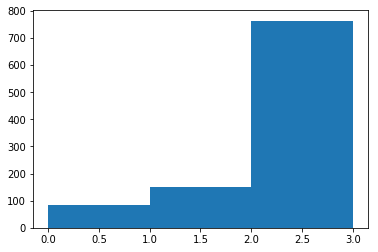

In [336]:
bits = 64
ix = []
for i in range(1000):
    A = random.randint(0, 2**256)
    B = random.randint(0, A)

    s = max(int(math.ceil(math.log2(A))) - bits, 0)
    a = A >> s
    b = B >> s
    ix += [lehmer_loop_3(a, b)]
plt.hist(ix, [0, 1, 2, 3])

**Hypothesis.** Any 256-bit GCD can be computed using at most 5 Lehmer matrices:

(array([ 4.,  0.,  0.,  0.,  0., 13.,  0.,  0.,  0., 83.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

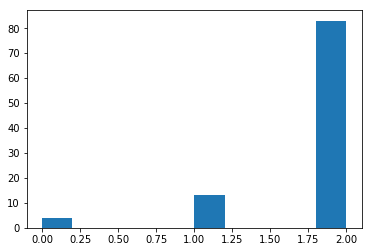

In [309]:
l = []
for b in range(256):
    for i in range(1000):
        A = random.randint(0, 2**b)
        B = random.randint(0, A)
        l.append(len(list(lehmer_accumulate(euclid_qs(A, B)))))
print(max(l))

In [65]:
list(lehmer_accumulate([25785, 2, 3, 1, 1, 1, 29, 23, 4, 1, 3, 3, 2, 1, 20, 1, 1, 1, 13, 2, 9, 4, 1, 1, 1, 1, 2, 3, 3, 4]))

[(41588875349823, 1072387447758585125, 178975154770675, 4614953105182700512)]

In [28]:
euclid_qs(17, 5)

[3, 2, 2]

In [29]:
17/5

3.4

In [30]:
3 + 1 /(2 + 1/2)

3.4

In [356]:
hex(14535145444257436950)

'0xc9b735c5639a1516'

In [358]:
lehmer_loop_3(0xe0befcaf1e3ca5f1, 0xc9b735c5639a1516, debug=True)

[12079776522, 6944202407, 5135574115, 1808628292]
[320831736, 1018828859, 1339660595, 2358489454]
[357461893, 1135151083, 1492612976, 2627764059]
k = i


0

In [359]:
6044159827974199924 | 2**63

15267531864828975732

In [360]:
0xe0befcaf1e3ca5f1

16194659139127649777

In [361]:
0xc9b735c5639a1516

14535145444257436950

In [362]:
lehmer_loop(16194659139127649777, 14535145444257436950)

[16194659139127649777, 14535145444257436950, 1659513694870212827, 1259035885295734334, 400477809574478493, 57602456572298855, 54863070140685363, 2739386431613492, 75341508415523, 27092128654664, 21157251106195, 5934877548469, 3352618460788, 2582259087681, 770359373107, 271180968360, 227997436387, 43183531973, 12079776522, 6944202407, 5135574115, 1808628292]
[None, 1, 8, 1, 3, 6, 1, 20, 36, 2, 1, 3, 1, 1, 3, 2, 1, 5, 3, 1, 1]
[1, 0, 1, 8, 9, 35, 219, 254, 5299, 191018, 387335, 578353, 2122394, 2700747, 4823141, 17170170, 39163481, 56333651, 320831736, 1018828859, 1339660595, 2358489454]
[0, 1, 1, 9, 10, 39, 244, 283, 5904, 212827, 431558, 644385, 2364713, 3009098, 5373811, 19130531, 43634873, 62765404, 357461893, 1135151083, 1492612976, 2627764059]
i = 18
[12079776522, 6944202407, 5135574115, 1808628292]
[320831736, 1018828859, 1339660595, 2358489454]
[357461893, 1135151083, 1492612976, 2627764059]
k = i + 1
19
1
[16194659139127649777, 14535145444257436950, 1659513694870212827, 12590358

(1018828859, 1339660595, 1135151083, 1492612976, False)

In [390]:
list(lehmer_accumulate(euclid_qs(0x518a5cc4c55ac5b050a0831b65e827e5e39fd4515e4e094961c61509e7870814,
                0x018a5cc4c55ac5b050a0831b65e827e5e39fd4515e4e094961c61509e7870814)[:34]))

[52, 1, 13, 1, 2, 4, 4, 1, 1, 1, 13, 1, 23, 1, 9, 3, 3, 5, 11, 6, 1, 3, 1, 1, 4, 2, 1, 1, 1, 1, 2, 1, 32, 1]


[(2927556694930003, 154961230633081597, 3017020641586254, 159696730135159213)]

In [385]:
114557320433621401 < 2927556694930003

False

In [391]:
5818365597666026993 > 14535145444257436950

False

In [392]:
10841422679839906593 > 15507080595343815048

False

In [393]:
gcd_euclid(14535145444257436950, 5818365597666026993)

(37, 7, -379355176803460069, 947685836737753349)

In [396]:
list(lehmer_accumulate(euclid_qs(15507080595343815048, 10841422679839906593)))

[1, 2, 3, 11, 6, 3, 13, 1, 2, 2, 3, 4, 3, 1, 1, 3, 1, 6, 1, 4, 1, 1, 1, 1, 3, 1, 862, 632, 1, 89]


[(40154122160696118,
  57434639988632077,
  3613807559946635531,
  5169026865114605016)]